<a href="https://colab.research.google.com/github/ICam99/geometriaComputacional/blob/main/proyectoFinalGeometria_IgnacioC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo para generar obstáculos poligonales simples dentro de un rectángulo.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from shapely.geometry import Polygon
import numpy as np

def generate_ngon(n_lados, center, scale=0.8, min_area=0.05):
    """Genera un polígono válido con n_lados centrado en 'center' y escala 'scale'."""
    for _ in range(5):  # hasta 5 intentos por polígono
        angles = np.sort(np.random.uniform(0, 2*np.pi, n_lados))
        radii = scale * np.random.uniform(0.5, 1.0, n_lados)
        x = center[0] + radii * np.cos(angles)
        y = center[1] + radii * np.sin(angles)

        poly = Polygon(zip(x, y))

        if poly.is_valid and poly.is_simple and poly.area > min_area:
            return x, y

    return None, None  # No se logró generar un polígono válido

def polygons_overlap(poly1, poly2):
    """Comprueba si dos polígonos se solapan usando bounding boxes."""
    x1_min, x1_max = min(poly1[0]), max(poly1[0])
    y1_min, y1_max = min(poly1[1]), max(poly1[1])
    x2_min, x2_max = min(poly2[0]), max(poly2[0])
    y2_min, y2_max = min(poly2[1]), max(poly2[1])

    return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)

def generate_obstacle_field(n_total_aristas, ancho=10, alto=10, max_intentos=2000):
    aristas_restantes = n_total_aristas
    obstaculos = []
    min_lados = 3
    max_lados = 8
    intentos = 0

    while aristas_restantes >= min_lados and intentos < max_intentos:
        lados = np.random.randint(min_lados, min(max_lados + 1, aristas_restantes + 1))
        cx = np.random.uniform(2.0, ancho - 2.0)
        cy = np.random.uniform(2.0, alto - 2.0)

        x, y = generate_ngon(lados, center=(cx, cy), scale=0.8)

        if x is None or y is None:
            intentos += 1
            continue  # polígono inválido

        colision = False
        for ox, oy in obstaculos:
            if polygons_overlap((x, y), (ox, oy)):
                colision = True
                break

        if not colision:
            obstaculos.append((x, y))
            aristas_restantes -= lados

        intentos += 1

    return obstaculos, ancho, alto

In [ ]:
# ==== PARÁMETROS ====
np.random.seed(62)
total_aristas = 100

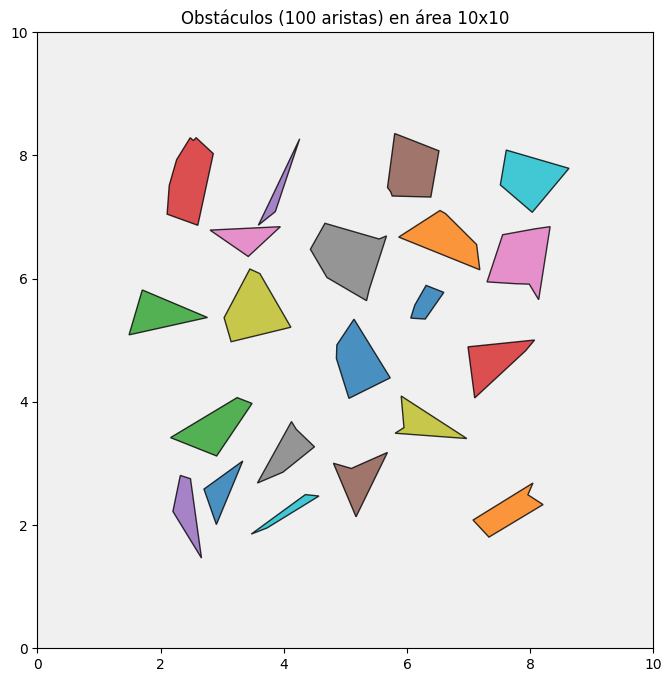

In [ ]:
# ==== GENERACIÓN Y VISUALIZACIÓN ====
obstaculos, ancho, alto = generate_obstacle_field(total_aristas)

plt.figure(figsize=(8, 8))
plt.xlim(0, ancho)
plt.ylim(0, alto)
plt.gca().set_aspect('equal')
plt.gca().set_facecolor('#f0f0f0')

for x, y in obstaculos:
    plt.fill(x, y, alpha=0.8, edgecolor='black')

plt.title(f'Obstáculos ({total_aristas} aristas) en área {ancho}x{alto}')
plt.show()

# Algoritmo para generar la descomposición trapezoidal

In [ ]:
from shapely.geometry import Polygon, LineString, Point, MultiPolygon
from shapely.ops import split
from shapely.validation import make_valid

In [ ]:
# Extrae los segmentos de todos los obstáculos
def extraer_segmentos(obstaculos):
    segmentos = []
    for ox, oy in obstaculos:
        puntos = list(zip(ox, oy))
        for i in range(len(puntos)):
            p1 = puntos[i]
            p2 = puntos[(i + 1) % len(puntos)]
            segmentos.append(LineString([p1, p2]))
    return segmentos

In [ ]:
# Genera regiones tipo trapezoides
def generar_trapezoides_reales(obstaculos, ancho, alto):
    segmentos = extraer_segmentos(obstaculos)

    # Obtener coordenadas x de vértices de obstáculos
    x_vertices = sorted(set([0, ancho] + [x for ox, _ in obstaculos for x in ox]))

    # Construir polígono del espacio libre
    bounding_box = Polygon([(0, 0), (ancho, 0), (ancho, alto), (0, alto)])
    espacio_ocupado = MultiPolygon([Polygon(zip(ox, oy)) for ox, oy in obstaculos])
    espacio_libre = bounding_box
    for pol in espacio_ocupado.geoms:
        espacio_libre = espacio_libre.difference(pol)

    trapezoides = []

    for i in range(len(x_vertices) - 1):
        x1 = x_vertices[i]
        x2 = x_vertices[i + 1]

        franja = Polygon([(x1, 0), (x2, 0), (x2, alto), (x1, alto)])

        # Intersección con el espacio libre
        zona = espacio_libre.intersection(franja)

        # Asegurar que se manejen múltiples polígonos si hay más de uno
        if zona.is_empty:
            continue
        elif zona.geom_type == 'Polygon':
            trapezoides.append(zona)
        elif zona.geom_type == 'MultiPolygon':
            trapezoides.extend([geom for geom in zona.geoms])


    trapezoides = [make_valid(t) for t in trapezoides if t.is_valid]
    print(f"Se generaron {len(trapezoides)} trapezoides.")
    return trapezoides

In [ ]:
# Función para graficar el resultado
def graficar_ambiente(obstaculos, trapezoides, ancho, alto):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, ancho)
    plt.ylim(0, alto)
    plt.gca().set_aspect('equal')
    plt.gca().set_facecolor('#ffffff')

    # Dibujar trapezoides reales
    for trap in trapezoides:
        x, y = trap.exterior.xy
        plt.fill(x, y, color='skyblue', alpha=0.5, edgecolor='blue', linewidth=0.5)

    # Dibujar obstáculos
    for ox, oy in obstaculos:
        plt.fill(ox, oy, color='gray', edgecolor='black')

    plt.title("Descomposición trapezoidal real del espacio libre")
    plt.show()

Se generaron 397 regiones tipo trapezoidales reales.


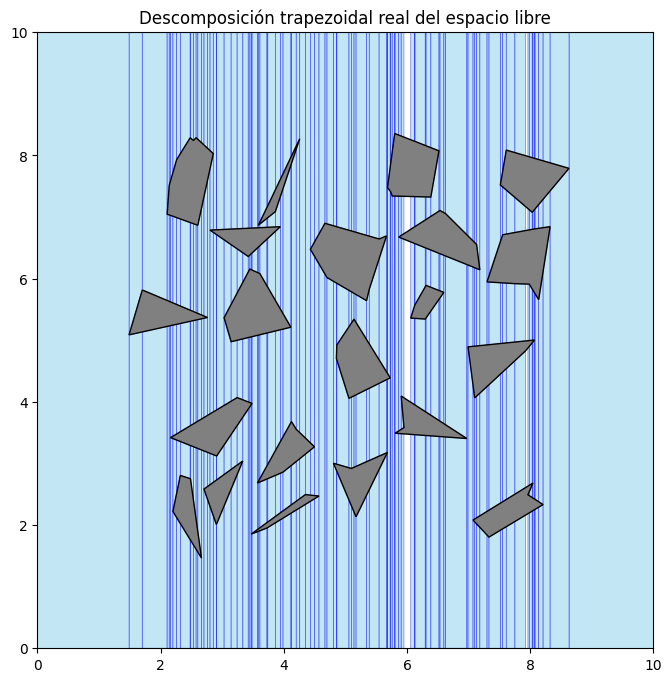

In [ ]:
trapezoides = generar_trapezoides_reales(obstaculos, ancho, alto)
graficar_ambiente(obstaculos, trapezoides, ancho, alto)

# Construcción de grafo de adyacencia

In [ ]:
import networkx as nx

In [ ]:
def construir_grafo_adyacencia(trapezoides):
    import networkx as nx
    G = nx.Graph()

    for i, t in enumerate(trapezoides):
        centroide = t.centroid
        G.add_node(i, centroide=(centroide.x, centroide.y))

    for i in range(len(trapezoides)):
        for j in range(i + 1, len(trapezoides)):
            if trapezoides[i].touches(trapezoides[j]):
                G.add_edge(i, j)

    print(f"Grafo creado con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")
    return G

In [ ]:
G = construir_grafo_adyacencia(trapezoides)

Grafo creado con 397 nodos y 451 aristas.


In [ ]:
def graficar_grafo_adyacencia(obstaculos, trapezoides, G, ancho, alto):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xlim(0, ancho)
    ax.set_ylim(0, alto)
    ax.set_facecolor('#f0f0f0')

    # Dibujar obstáculos
    for ox, oy in obstaculos:
        plt.fill(ox, oy, color='gray', edgecolor='black')

    # Dibujar trapezoides
    for t in trapezoides:
        x, y = t.exterior.xy
        plt.fill(x, y, color='skyblue', alpha=0.4, edgecolor='blue', linewidth=0.5)

    # Dibujar nodos del grafo
    for node in G.nodes(data=True):
        x, y = node[1]['centroide']
        plt.plot(x, y, 'ro', markersize=4)
        plt.text(x, y, str(node[0]), fontsize=8, color='darkred', ha='center', va='center')

    # Dibujar aristas del grafo
    for i, j in G.edges():
        x1, y1 = G.nodes[i]['centroide']
        x2, y2 = G.nodes[j]['centroide']
        plt.plot([x1, x2], [y1, y2], 'k-', linewidth=1)

    plt.title("Grafo de adyacencia entre trapezoides")
    plt.show()

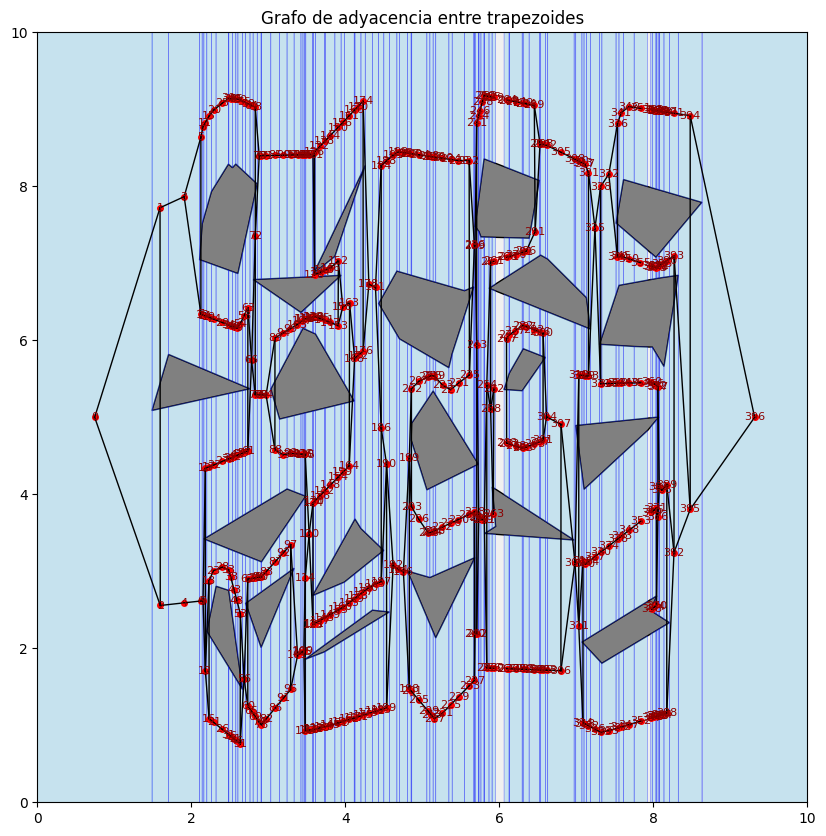

In [ ]:
graficar_grafo_adyacencia(obstaculos, trapezoides, G, ancho, alto)

In [ ]:
import random
from shapely.geometry import Point

def agregar_puntos_medios_y_conexiones(G, trapezoides):
    idx_offset = len(G.nodes)
    for i, t in enumerate(trapezoides):
        centroide = Point(G.nodes[i]['centroide'])
        coords = list(t.exterior.coords)
        for j in range(len(coords) - 1):
            x1, y1 = coords[j]
            x2, y2 = coords[j + 1]
            if abs(x1 - x2) < 1e-6:  # vertical
                xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
                node_id = idx_offset
                G.add_node(node_id, centroide=(xm, ym))
                dist = centroide.distance(Point(xm, ym))
                G.add_edge(i, node_id, weight=dist)
                idx_offset += 1
    print(f"Total de nodos con puntos medios añadidos: {G.number_of_nodes()}")

In [ ]:
def encontrar_camino_y_dibujar(G, trapezoides, obstaculos, ancho, alto, intentos=20):
    import matplotlib.pyplot as plt

    trapezoides_ids = [i for i in range(len(trapezoides))]

    for _ in range(intentos):
        start, end = random.sample(trapezoides_ids, 2)
        try:
            path = nx.shortest_path(G, source=start, target=end, weight='weight')
            break  # Si encontró un camino, salimos del loop
        except nx.NetworkXNoPath:
            continue
    else:
        print("No se encontró ningún par de trapezoides conectados después de varios intentos.")
        return

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xlim(0, ancho)
    ax.set_ylim(0, alto)
    ax.set_facecolor('#f0f0f0')

    for ox, oy in obstaculos:
        plt.fill(ox, oy, color='gray', edgecolor='black')

    for t in trapezoides:
        x, y = t.exterior.xy
        plt.fill(x, y, color='skyblue', alpha=0.4, edgecolor='blue', linewidth=0.5)

    for node in G.nodes(data=True):
        x, y = node[1]['centroide']
        plt.plot(x, y, 'ro', markersize=3)

    path_coords = [G.nodes[n]['centroide'] for n in path]
    path_x, path_y = zip(*path_coords)
    plt.plot(path_x, path_y, color='yellow', linewidth=2, label='Ruta más corta')

    plt.scatter(*G.nodes[start]['centroide'], color='green', s=100, label='Inicio')
    plt.scatter(*G.nodes[end]['centroide'], color='purple', s=100, label='Fin')

    plt.title("Ruta más corta entre celdas")
    plt.legend()
    plt.show()

Total de nodos con puntos medios añadidos: 1232


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


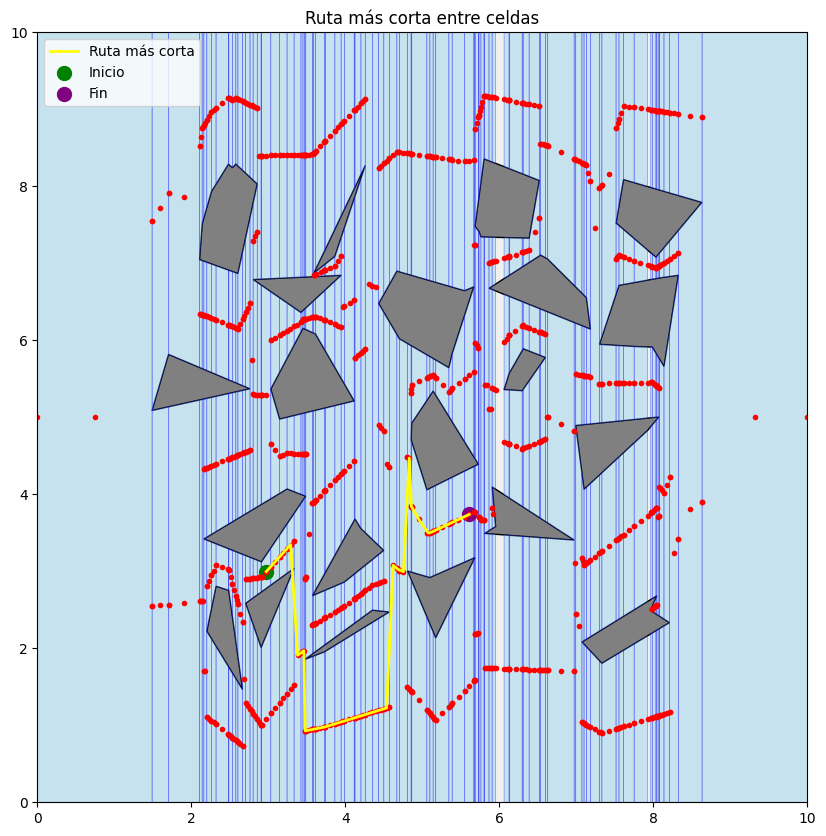

In [ ]:
agregar_puntos_medios_y_conexiones(G, trapezoides)
encontrar_camino_y_dibujar(G, trapezoides, obstaculos, ancho, alto)

# Evaluación de tiempo

In [ ]:
import time

In [ ]:
def evaluar_tiempos_por_aristas(aristas_list, repeticiones=3, ancho=10, alto=10, max_reintentos=5):
    tiempos_generacion = []
    tiempos_trapezoides = []
    tiempos_grafo = []
    tiempos_ruta = []

    for total_aristas in aristas_list:
        t_gen, t_trap, t_grafo, t_plan = [], [], [], []

        for _ in range(repeticiones):
            reintentos = 0
            exito = False

            while reintentos < max_reintentos:
                try:
                    # 1. Generación de obstáculos
                    start = time.perf_counter()
                    obstaculos, w, h = generate_obstacle_field(total_aristas, ancho, alto)
                    t_gen.append(time.perf_counter() - start)

                    # 2. Descomposición trapezoidal
                    start = time.perf_counter()
                    trapezoides = generar_trapezoides_reales(obstaculos, ancho, alto)
                    trapezoides = [t.buffer(0) for t in trapezoides if t.is_valid]
                    t_trap.append(time.perf_counter() - start)

                    # 3. Grafo
                    start = time.perf_counter()
                    G = construir_grafo_adyacencia(trapezoides)
                    agregar_puntos_medios_y_conexiones(G, trapezoides)
                    t_grafo.append(time.perf_counter() - start)

                    # 4. Ruta
                    start = time.perf_counter()
                    ids = [i for i in range(len(trapezoides))]
                    path_found = False
                    for _ in range(10):
                        a, b = random.sample(ids, 2)
                        try:
                            nx.shortest_path(G, source=a, target=b, weight='weight')
                            path_found = True
                            break
                        except:
                            continue
                    t_plan.append(time.perf_counter() - start if path_found else 0)

                    exito = True
                    break  # salir del ciclo de reintentos si todo fue exitoso

                except Exception as e:
                    print(f"Intento {reintentos+1} fallido para {total_aristas} aristas: {e}")
                    reintentos += 1

            if not exito:
                print(f"No se pudo completar la repetición con {total_aristas} aristas tras {max_reintentos} intentos.")
                t_gen.append(0)
                t_trap.append(0)
                t_grafo.append(0)
                t_plan.append(0)

        # Guardar promedios
        tiempos_generacion.append(sum(t_gen) / repeticiones)
        tiempos_trapezoides.append(sum(t_trap) / repeticiones)
        tiempos_grafo.append(sum(t_grafo) / repeticiones)
        tiempos_ruta.append(sum(t_plan) / repeticiones)

    return {
        'aristas': aristas_list,
        'generacion': tiempos_generacion,
        'trapezoides': tiempos_trapezoides,
        'grafo': tiempos_grafo,
        'ruta': tiempos_ruta
    }

In [ ]:
def graficar_tiempos(resultados):
    aristas = resultados['aristas']
    plt.figure(figsize=(10,6))
    plt.plot(aristas, resultados['generacion'], label='Generación de obstáculos')
    plt.plot(aristas, resultados['trapezoides'], label='Descomposición trapezoidal')
    plt.plot(aristas, resultados['grafo'], label='Grafo de adyacencia')
    plt.plot(aristas, resultados['ruta'], label='Planificación de ruta')
    plt.xlabel("Número total de aristas")
    plt.ylabel("Tiempo promedio (segundos)")
    plt.title("Evaluación de rendimiento según número de aristas")
    plt.legend()
    plt.grid(True)
    plt.show()

Se generaron 362 regiones tipo trapezoidales reales.
Grafo creado con 362 nodos y 408 aristas.
Total de nodos con puntos medios añadidos: 1122
Se generaron 357 regiones tipo trapezoidales reales.
Grafo creado con 357 nodos y 397 aristas.
Total de nodos con puntos medios añadidos: 1108
Se generaron 357 regiones tipo trapezoidales reales.
Grafo creado con 357 nodos y 407 aristas.
Total de nodos con puntos medios añadidos: 1109
Se generaron 383 regiones tipo trapezoidales reales.
Grafo creado con 383 nodos y 442 aristas.
Total de nodos con puntos medios añadidos: 1189
Se generaron 398 regiones tipo trapezoidales reales.
Grafo creado con 398 nodos y 451 aristas.
Total de nodos con puntos medios añadidos: 1234
Se generaron 932 regiones tipo trapezoidales reales.
Grafo creado con 932 nodos y 1003 aristas.
Total de nodos con puntos medios añadidos: 2865
Se generaron 885 regiones tipo trapezoidales reales.
Grafo creado con 885 nodos y 965 aristas.
Total de nodos con puntos medios añadidos: 272

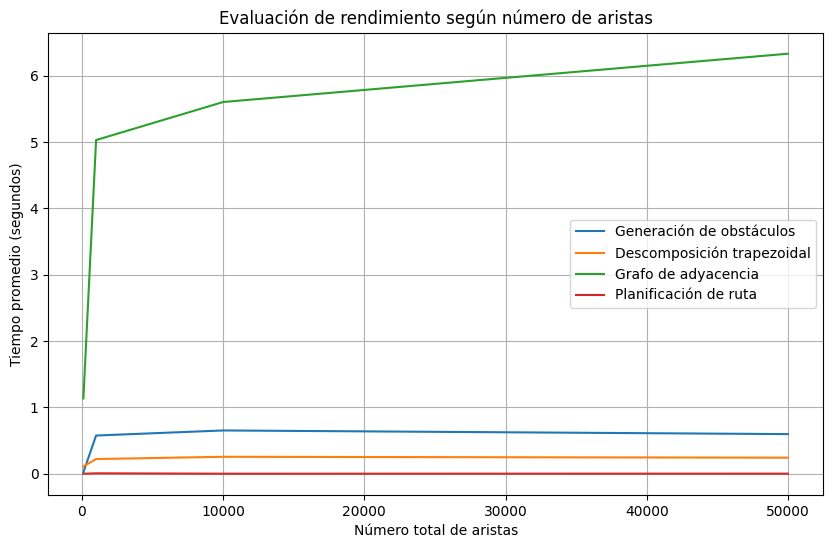

In [ ]:
aristas_list = [100, 1000, 10000, 50000]
resultados = evaluar_tiempos_por_aristas(aristas_list, repeticiones=5)
graficar_tiempos(resultados)